# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import numpy as np
import pandas as pd
import torch
import transformers
from tqdm import notebook
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from catboost import cv, Pool
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils import class_weight
import lightgbm as lgb

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize 
from nltk.corpus import wordnet
# nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
# stop_words = stopwords.words('english')
import re

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [3]:
# pip install pymystem3
# from pymystem3 import Mystem
# m = Mystem() 

In [4]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [5]:
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'>Данные загружены корректно, первичный осмотр проведен.</font>

<AxesSubplot:xlabel='toxic', ylabel='count'>

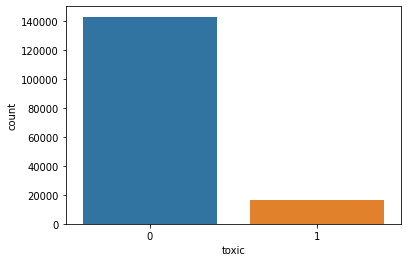

In [7]:
import seaborn as sns
sns.countplot(x='toxic', data=df)

Классы несбалансированы, учесть это при построении моделей и разделения на трейн и тест.

In [8]:
df = df.drop(columns='Unnamed: 0')

In [9]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [10]:
%%time
# Функция для очистки текста 
def clean_text(text):
    text = text.lower()
    return " ".join(re.sub(r"[^a-z]", ' ', text).split()) 
 
# создаем список для хранения преобразованных данных 
processed_text = []
# загружаем стоп-слова для английского языка
stop_words = stopwords.words('english')
# инициализируем лемматайзер 
lemmatizer = WordNetLemmatizer()
 

# для каждого сообщения text из столбца data['text']
for text in df['text']:
    # cleaning 
    text = clean_text(text)   
    # tokenization
    text = word_tokenize(text)       
    # удаление стоп-слов
    text = [word for word in text if word not in stop_words]     
    # лемматизация
    text = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in text]
#     text = [m.lemmatize(w) for w in text] 
# pymystem3 сработала не очень хорошо, 
# потом нам объяснили, что она для русского текста
     
    # добавляем преобразованный текст в список processed_text
    processed_text.append(text)
    
# Сохраняем результат преобразования в новой колонке 'lemm_text'
df['lemm_text'] = processed_text

CPU times: user 11min 54s, sys: 56.5 s, total: 12min 51s
Wall time: 12min 51s


In [11]:
df.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,"[explanation, edits, make, username, hardcore,..."
1,D'aww! He matches this background colour I'm s...,0,"[aww, match, background, colour, seemingly, st..."
2,"Hey man, I'm really not trying to edit war. It...",0,"[hey, man, really, try, edit, war, guy, consta..."
3,"""\nMore\nI can't make any real suggestions on ...",0,"[make, real, suggestion, improvement, wonder, ..."
4,"You, sir, are my hero. Any chance you remember...",0,"[sir, hero, chance, remember, page]"


In [12]:
df['lemm_text'] = df['lemm_text'].apply(lambda x: ' '.join(x))

In [13]:
df.head(10)

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation edits make username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,aww match background colour seemingly stuck th...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man really try edit war guy constantly rem...
3,"""\nMore\nI can't make any real suggestions on ...",0,make real suggestion improvement wonder sectio...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page
5,"""\n\nCongratulations from me as well, use the ...",0,congratulation well use tool well talk
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,cocksucker piss around work
7,Your vandalism to the Matt Shirvington article...,0,vandalism matt shirvington article revert plea...
8,Sorry if the word 'nonsense' was offensive to ...,0,sorry word nonsense offensive anyway intend wr...
9,alignment on this subject and which are contra...,0,alignment subject contrary dulithgow


**Train Test Split**

In [14]:
X = df['lemm_text']
y = df['toxic']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 19, stratify=y)

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Здорово , что у нас есть выборка для тестов!</font>

**TF-IDF**

In [16]:
vectorizer = TfidfVectorizer(min_df=1, stop_words='english', sublinear_tf=True, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(X_train.values)
X_test = vectorizer.transform(X_test.values)
# features = vectorizer.fit_transform(df['lemm_text'].values)

## Обучение

### Logistic Regression

In [17]:
lr_model = LogisticRegression(random_state=19, class_weight='balanced')

In [18]:
param_grid_lr = {'max_iter':[100, 500, 1000]}  

In [19]:
# lg_model_grid, lg_f1_grid = get_gridsearchcv(X_train, y_train,
#                        lg_model, param_grid_lg, cv=5, scoring_fit='f1') #scoring_fit='accuracy'

lr_model_grid = GridSearchCV(lr_model, param_grid = param_grid_lr, 
                           cv=5, n_jobs=-1, 
                           scoring='f1', verbose=2)

In [20]:
%%time
lr_model_grid.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END .......................................max_iter=100; total time= 1.2min
[CV] END .......................................max_iter=100; total time= 1.2min
[CV] END .......................................max_iter=100; total time=  57.4s
[CV] END .......................................max_iter=100; total time=  47.5s
[CV] END .......................................max_iter=100; total time= 1.6min
[CV] END .......................................max_iter=500; total time= 1.2min
[CV] END .......................................max_iter=500; total time= 1.2min
[CV] END .......................................max_iter=500; total time=  56.5s
[CV] END .......................................max_iter=500; total time=  47.4s
[CV] END .......................................max_iter=500; total time= 1.6min
[CV] END ......................................max_iter=1000; total time= 1.2min
[CV] END ......................................ma

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=19),
             n_jobs=-1, param_grid={'max_iter': [100, 500, 1000]}, scoring='f1',
             verbose=2)

In [21]:
lr_model_grid.best_params_

{'max_iter': 100}

In [22]:
lr_model_grid = lr_model_grid.best_estimator_

**Значения F1 модели Logistic Regression:**

In [23]:
from sklearn.metrics import f1_score
lr_f1_train = f1_score(y_train, lr_model_grid.predict(X_train))
lr_f1_train

0.9012770137524557

In [24]:
lr_f1_test = f1_score(y_test, lr_model_grid.predict(X_test))
lr_f1_test

0.7658867506576215

### LGBMClassifier

In [28]:
lgbm_model = lgb.LGBMClassifier(random_state=19, class_weight='balanced')

In [29]:
param_grid_lgbm = {
    'n_estimators': [10, 20, 40],
    'learning_rate': [0.2, 0.5, 0.95]}

In [31]:
lgbm_model_grid = GridSearchCV(lgbm_model, param_grid = param_grid_lgbm, scoring='f1', cv=5)

In [32]:
%%time
lgbm_model.fit(X_train, y_train)

CPU times: user 6min 7s, sys: 0 ns, total: 6min 7s
Wall time: 6min 8s


LGBMClassifier(class_weight='balanced', random_state=19)

**Значения F1 модели LGBMClassifier:**

In [33]:
lgbm_f1_train = f1_score(y_train, lgbm_model.predict(X_train))
lgbm_f1_train

0.7608410892795588

In [34]:
lgbm_f1_test = f1_score(y_test, lgbm_model.predict(X_test))
lgbm_f1_test

0.7340177960301163

**Итого:**

In [43]:
models_table = pd.DataFrame({
    'Model': ['LogisticR','LGBM'],
    'Train_F1': [lr_f1_train, 
                 lgbm_f1_train],
    'Test_F1': [lr_f1_test, 
                 lgbm_f1_test]
})
models_table.sort_values(by='Test_F1', ascending=False)

,Model,Train_F1,Test_F1
0,LogisticR,0.901277,0.765887
1,LGBM,0.760841,0.734018


## Выводы

Необходимое значение метрики F1 не меньше 0.75 достигнуто при помощи моделей Логистической Регрессии.

Итоговое значение на тестовой выборке - **0.765887**. Условие выполнено.